In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib




# Ephaptic Coupling #

In [2]:
import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron

## Fetch model files
### Cell type and cell parameters ###

In [3]:
if not os.path.isfile('L5bPCmodelsEH/morphologies/cell1.asc'):
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=139653&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('L5bPCmodelsEH.zip', 'r')
    myzip.extractall('.')
    myzip.close()

#compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('L5bPCmodelsEH/mod/')
    
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-6,
    'tstart' : -159,
    'tstop' : 10,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
}

### Creating generator_cell

In [4]:
LFPy.cell.neuron.h("forall delete_section()")

generator_cell = LFPy.TemplateCell(**cellParameters)
generator_cell.set_rotation(x=4.729, y=-3.166)
#for sec in generator_cell.allseclist:
#   for seg in sec:
#       seg.e_pas = -59.5

### Puting Synapse ###

In [5]:
synapse = LFPy.Synapse(generator_cell, 
                       idx = generator_cell.get_idx("soma[0]"),
                       syntype = 'Exp2Syn', 
                       weight = 0.005, 
                       e = 15, 
                       tau1 = 0.5,
                       tau2 = 2,
                       record_current = True)
synapse.set_spike_times(np.array([2.,8]))



### Measuring the external field in the positions of receptor_cell

In [6]:
# Let's put electrodes at each segment of the second cell
electrodeParameters = {
    'sigma' : 0.3,                  # extracellular conductivity
    'x' : generator_cell.xmid,      # x,y,z-coordinates of contacts
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}

electrode = LFPy.RecExtElectrode(**electrodeParameters)
generator_cell.simulate(electrode = electrode,rec_imem=True)

#plt.plot(electrode.LFP)


Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments
Adjusting r-distance to soma segments


### Ploting initial conditions

([<matplotlib.lines.Line2D at 0x7f1794cc2090>],
 Text(0.5, 1.0, 'somatic voltage (mV)'))

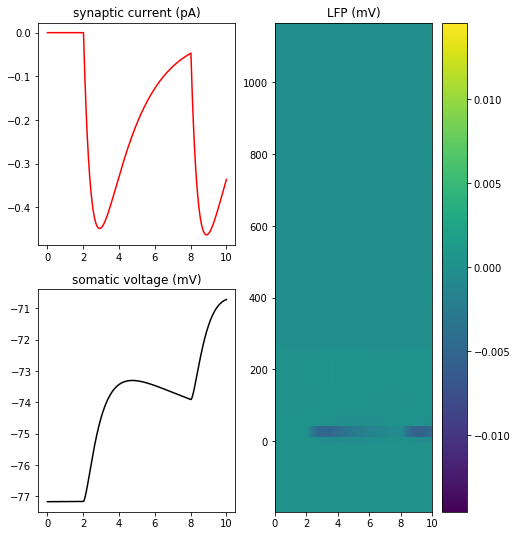

In [7]:
plt.figure(figsize=(12, 9))
plt.subplot(133)
pcolormesh(generator_cell.tvec, electrode.z, electrode.LFP,
           vmin=-abs(electrode.LFP).max(), vmax=abs(electrode.LFP).max())
colorbar()
title('LFP (mV)')

plt.subplot(232)
plt.plot(generator_cell.tvec, synapse.i, 'r'), plt.title('synaptic current (pA)')

plt.subplot(235)
plt.plot(generator_cell.tvec, generator_cell.somav, 'k'), plt.title('somatic voltage (mV)')




#savefig('LFPy-example-1.pdf', dpi=200)

### Creating Receptor_cell

In [8]:
# perform NEURON simulation, results saved as attributes in the cell instance
receptor_cell = LFPy.TemplateCell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 100

t = np.arange(electrode.LFP.shape[1]) * receptor_cell.dt
receptor_cell.insert_v_ext(electrode.LFP, t)
receptor_cell.simulate(rec_vmem=True)

Overwriting custom temperature of 34.00. New temperature is 34.00


In [9]:
#plt.plot(receptor_cell.vmem)
#print(receptor_cell.vmem)

#plt.plot(t,receptor_cell.vmem[140])
#plt.xlabel("Time")
#print(max(receptor_cell.vmem[140]))

In [10]:
positions = np.array(list(zip(receptor_cell.xmid, receptor_cell.zmid)))

target = np.array([200,600])
target_index = ((positions - target)**2).sum(axis=1).argmin()

target_pos = positions[target_index]



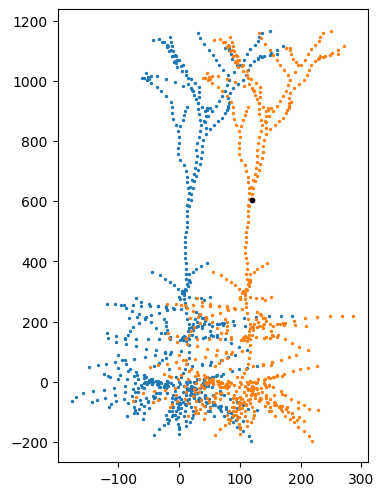

In [11]:
plt.figure(dpi=100,
          figsize=(4,6))

plt.scatter(generator_cell.xmid, generator_cell.zmid,s=2)
plt.scatter(receptor_cell.xmid, receptor_cell.zmid,s=2)

plt.scatter(target_pos[0],target_pos[1],s=10,color='k')

Text(0.5, 1.0, 'LFP (mV)')

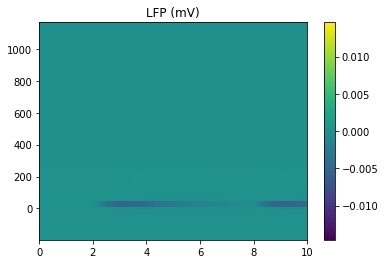

In [12]:
pcolormesh(generator_cell.tvec, electrode.z, electrode.LFP,
           vmin=-abs(electrode.LFP).max(), vmax=abs(electrode.LFP).max())
colorbar()
title('LFP (mV)')

642
642
<built-in method min of numpy.ndarray object at 0x7f1794c1c530>


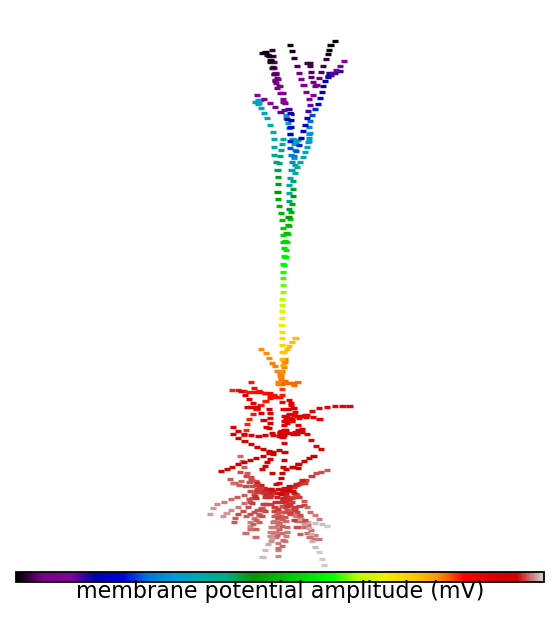

In [23]:
# plot generator cell

def plotstuff(receptor_cell, electrode):
    fig = plt.figure(dpi=160)
    
    ax1 = fig.add_axes([0.05, 0.1, 0.55, 0.9], frameon=False)
    cax = fig.add_axes([0.05, 0.115, 0.55, 0.015])
    
    #plot each electrode as a point
    #ax1.plot(electrode.x, electrode.z, '.', marker='o', markersize=1, color='k',zorder=0)  
   
    
    #normalize to min peak
    Vmem_min = receptor_cell.vmem.min(axis=1)
    Vmem_norm = -(receptor_cell.vmem.T / Vmem_min).T  #T is the transpose
    print(len(Vmem_min))
    print(len(receptor_cell.vmem))
    
    i = 0
    zips = []
    for x in Vmem_norm:
        zips.append(list(zip(receptor_cell.tvec*1.6 + electrode.x[i] + 2,
                        x*12 + electrode.z[i])))
        i += 1
    
    line_segments = LineCollection(zips,
                                    linewidths = (1.5),
                                    linestyles = 'solid',
                                    cmap='nipy_spectral',
                                    zorder=1,
                                    rasterized=True)
    
    line_segments.set_array(np.log10(-Vmem_min))
    ax1.add_collection(line_segments)
    
    axcb = fig.colorbar(line_segments, cax=cax, orientation='horizontal')
    axcb.outline.set_visible(True)
    xticklabels = np.array([-0.1  , -0.05 , -0.02 , -0.01 , -0.005, -0.002])
    xticks = np.log10(-xticklabels)
    axcb.set_ticks(xticklabels)
    axcb.set_ticklabels(np.round(-10**xticks, decimals=3))  
    axcb.set_label('membrane potential amplitude (mV)', va='center')
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    axis = ax1.axis(ax1.axis('equal'))
    ax1.set_xlim(axis[0]*1.02, axis[1]*1.02)
    
    return fig

fig = plotstuff(receptor_cell, electrode)
print(receptor_cell.vmem.min)

In [24]:
print(receptor_cell.vmem)

[[-77.17526738 -77.17520353 -77.17513973 ... -77.13188169 -77.13190379
  -77.13192607]
 [-77.21993811 -77.21987379 -77.21980951 ... -77.18493406 -77.18490059
  -77.18486735]
 [-77.28833825 -77.2882732  -77.2882082  ... -77.25493229 -77.25488813
  -77.25484413]
 ...
 [-77.11955885 -77.1194952  -77.1194316  ... -77.08832384 -77.08827509
  -77.08822639]
 [-77.1902855  -77.19022161 -77.19015777 ... -77.15392769 -77.1539035
  -77.15387958]
 [-77.20527503 -77.20521111 -77.20514724 ... -77.17276875 -77.17272192
  -77.17267535]]


In [25]:
print(receptor_cell.vmem.min(axis=1))

[-77.17526738 -77.21993811 -77.28833825 -77.35455997 -77.41481
 -77.46369557 -77.50133875 -77.52781489 -77.5431901  -77.56002433
 -77.32821045 -77.35748226 -77.38946819 -77.41310692 -77.42844426
 -77.43549468 -77.37406362 -77.43636817 -77.48756583 -77.52778195
 -77.55714089 -77.63570103 -77.69809818 -77.73952987 -77.76019303
 -77.27889996 -77.330797   -77.43976505 -77.46329607 -77.47953519
 -77.51372563 -77.5308537  -77.21118366 -77.25250827 -77.26891604
 -77.27472826 -77.32647742 -77.35345723 -77.25085518 -77.29600216
 -77.35015452 -77.47249269 -77.57359584 -77.65392432 -77.71384607
 -77.75363975 -77.7734851  -77.3491946  -77.391832   -77.42581842
 -77.45121413 -77.46807231 -77.48915169 -77.50602797 -77.26821802
 -77.27532666 -77.2858537  -77.19820629 -77.2371823  -77.27683371
 -77.30431698 -77.29476327 -77.30882879 -77.30901056 -77.34512151
 -77.37016868 -77.37775517 -77.38221909 -77.30510059 -77.40241235
 -77.45358999 -77.47808884 -77.49029933 -77.46220898 -77.49174479
 -77.51531708